# Google Trends Data

This program obtains Google Trends Data using an unofficial API called [pytrends](https://github.com/GeneralMills/pytrends). Thank you to the creators!

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import lxml
import requests
import requests_cache
import pytrends
from pytrends.request import TrendReq
from bs4 import BeautifulSoup
from collections import Counter
from matplotlib import pyplot as plt
plt.style.use('ggplot')
requests_cache.install_cache("cache")

# required info
google_username = "***@gmail.com"
google_password = "***!"

In [2]:
# Login to Google. Only need to run this once, the rest of requests will use the same session.
pytrend = TrendReq(google_username, google_password, custom_useragent=None)

I first tried to look at all the search terms once in one payload, but that gave me different results than if I searched the terms separately. The reason is because when I used all the terms at once, the trends data returned was actually comparing each of the search terms and their popularity to each other. This is not what we wanted, so I decided to do them all separately.

**A side note:** According to the [Google Trends Search Tips](https://support.google.com/trends/answer/4359582?hl=en) page, searching a term like *tennis shoes* results in "searches containing both tennis and shoes in any order. Results can also include searches like red tennis shoes, funny shoes for tennis, or tennis without shoes." Therefore, I chose to use terms like *walmart stock price* so that each word would be considered as well as many combinations of these words.

We decided to start by taking a look at five companies from different sectors to analyze their search terms: Walmart, Goldman Sachs, Exxon Mobile, Facebook, and Nike.

In [27]:
# list of test search terms
search_list = ['walmart stock price', 'goldman sachs stock price', 'exxon mobile stock price', 'facebook stock price', 'nike stock price']

# get the comparison search data
pytrend.build_payload(kw_list = search_list, geo = 'US', timeframe = 'today 3-m')
compare_df = pytrend.interest_over_time()
compare_df.head()

,walmart stock price,goldman sachs stock price,exxon mobile stock price,facebook stock price,nike stock price
date,,,,,
2016-12-01,32,3,0,42,15
2016-12-02,33,5,0,50,22
2016-12-03,7,7,0,19,3
2016-12-04,14,5,0,22,3
2016-12-05,27,5,0,43,20


Because of the way the API is structured, I had to make five separate pyloads and get the individual data frames that way before combining them into a single data frame. Notice that the numbers are different from the data frame above!

Before that, we quickly needed to change the search term list into a list of lists with each term in its own list. This is because the API requires the keywords to be in a list format.

In [6]:
# function to quickly change the search term list into a list of lists
def listit(t):
    term_listed = []
    term_listed.append(t)
    return term_listed

In [47]:
search_list2 = [listit(t) for t in search_list]
search_list2

[['walmart stock price'],
 ['goldman sachs stock price'],
 ['exxon mobile stock price'],
 ['facebook stock price'],
 ['nike stock price']]

In [50]:
# combine all data frames by column since the indexes are the same anyways
all_df = pd.concat([get_term_df(search_term) for search_term in search_list2], axis = 1)
all_df.head()

,walmart stock price,goldman sachs stock price,exxon mobile stock price,facebook stock price,nike stock price
date,,,,,
2016-12-01,79,25,0,42,51
2016-12-02,80,50,0,50,74
2016-12-03,17,66,0,19,11
2016-12-04,33,48,0,22,11
2016-12-05,65,48,0,43,67


We also chose to focus on data from the US and from the last three years. This is important because we wanted to obtain the full 3 years of data, but then only really look at the last six months. If we requested only the last 3 months of data, then we would be getting numbers that were normalized over only the last three months, so a small deviation might seem large at the small scale. For this reason, we wanted to obtain results from the last three years so that big events are actually big events.

In [9]:
# function to get each company's data frame separately
def get_term_df(term, cat_num):
    pytrend.build_payload(kw_list = term, cat = cat_num, geo = 'US', timeframe = '2014-01-05 2017-03-11')
    new_df = pytrend.interest_over_time()
    return new_df

The API returns per-week data. After figuring out how the API worked and being able to get the right kind of data, we decided to focus in on one company and get all the information for it. This way, we can replicate the process with other companies. Another element we decided to encorporate was the categories feature on Google Trends.

Example: If you search for jaguar, you can add a category to indicate if you mean the animal or the car manufacturer.

We decided to use the three most relevant categories to us, Financial, Business & Industrial, and News. Even if we are looking at a technology company like Apple for example, we still would want to use the same categories to obtain more precise results. 

Our example company is Cocoa-Cola. We considered all possible variations of the company's name as well as their ticker symbol. Since we are using the Financial category as well, our resutls will include search terms like "losses" & "price".

In [7]:
KO_search_terms = ['coca-cola', '"coca cola"', 'KO', 'coke']
cat_list = [7,12,16]
cat_names = ['Financial', 'Business & Industrial', 'News']

KO_list = [listit(t) for t in KO_search_terms]
KO_list

[['coca-cola'], ['"coca cola"'], ['KO'], ['coke']]

In [10]:
all_df = pd.concat([get_term_df(x, i) for x in KO_list for i in cat_list], axis = 1)

In [11]:
reduced_df = all_df.loc["2016-09-13":"2017-03-13"]
reduced_df.head()

,coca-cola,coca-cola,coca-cola,"""coca cola""","""coca cola""","""coca cola""",KO,KO,KO,coke,coke,coke
date,,,,,,,,,,,,
2016-09-18,100,34,28,71,11,40,30,64,13,32,27,16
2016-09-25,43,29,20,84,11,32,44,65,16,34,31,87
2016-10-02,21,36,28,75,11,39,43,60,16,31,27,19
2016-10-09,50,32,24,66,11,40,50,68,17,32,27,51
2016-10-16,78,40,32,67,11,38,53,71,17,40,27,20


As you can see above, we obtained all the data and then sectioned off the last six months to use for our analysis. We then took the average by the search term.

In [12]:
#by_term = pd.concat([get_term_df(x, i) for x in KO_list for i in cat_list], axis = 1)
by_term_avg = reduced_df.groupby(np.arange(len(reduced_df.columns))//3, axis=1).mean()
by_term_avg = np.round(by_term_avg, decimals=2)
by_term_avg.columns = KO_search_terms
by_term_avg.head()

,coca-cola,"""coca cola""",KO,coke
date,,,,
2016-09-18,54.00,40.67,35.67,25.00
2016-09-25,30.67,42.33,41.67,50.67
2016-10-02,28.33,41.67,39.67,25.67
2016-10-09,35.33,39.00,45.00,36.67
2016-10-16,50.00,38.67,47.00,29.00


We then decided that it would actually be more useful to aggregate by category and see if a certain category behaved differently than the others.

In [13]:
by_cat = pd.concat([get_term_df(x, i) for i in cat_list for x in KO_list], axis = 1)
by_cat_avg = reduced_df.groupby(np.arange(len(reduced_df.columns))//4, axis=1).mean()
by_cat_avg.columns = cat_names
by_cat_avg.head()

,Financial,Business & Industrial,News
date,,,
2016-09-18,58.25,36.25,22.00
2016-09-25,44.00,38.00,42.00
2016-10-02,40.00,38.25,23.25
2016-10-09,43.00,42.25,31.75
2016-10-16,54.25,43.25,26.00


Just to get a visual sense of the different categories and their results, here is a plot of the data.

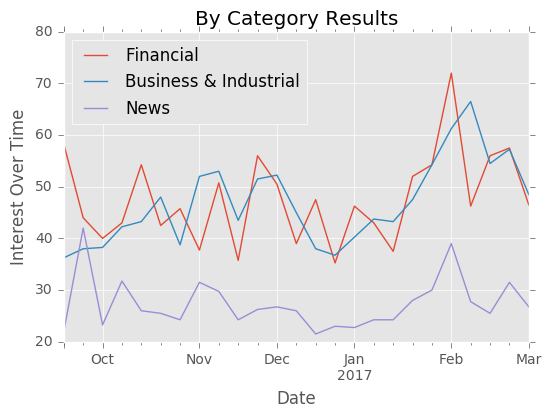

In [14]:
by_cat_avg.plot()
plt.title('By Category Results')
plt.xlabel('Date')
plt.ylabel('Interest Over Time')
plt.show()

Looking at the plot above, we can see that for the most part, the three categories move in the same direction. This is reassuring to us when we average the three categories into one column for further use.

In [15]:
result = by_cat_avg.mean(axis=1)
result = result.tolist()
result

[38.833333333333336,
 41.333333333333336,
 33.833333333333336,
 39.0,
 41.166666666666664,
 38.666666666666664,
 36.25,
 40.416666666666664,
 44.5,
 34.5,
 44.583333333333336,
 43.166666666666664,
 36.666666666666664,
 35.666666666666664,
 31.666666666666668,
 36.416666666666664,
 37.0,
 35.0,
 42.5,
 46.166666666666664,
 57.416666666666664,
 46.833333333333336,
 45.333333333333336,
 48.75,
 40.583333333333336]